In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd

In [3]:
java_dataset = pd.read_csv('/content/drive/MyDrive/machine learning/Datasets/merged dataset_FE_LM_GC_DC_class balancer.csv', sep=',', encoding='iso-8859-1')

In [4]:
csharp_dataset_base = pd.read_csv('/content/drive/MyDrive/machine learning/Datasets/GeneratedDataset_CSharp.csv', sep=';', encoding='iso-8859-1')
csharp_dataset_neg = csharp_dataset_base.loc[csharp_dataset_base.Smell == 0]
csharp_dataset_neg = csharp_dataset_neg.loc[csharp_dataset_neg.DataSet != "feature_envy"]

csharp_dataset = csharp_dataset_base.loc[csharp_dataset_base.DataSet == "feature_envy"]
csharp_dataset = pd.concat([csharp_dataset_neg, csharp_dataset], axis=0)

In [5]:
import warnings
warnings.filterwarnings("ignore")

## **PREDICTOR AND TARGET ATTRIBUTES**

In [6]:
# Java Dataset
java_dataset_features = [8,10,11,13,14,15,17,18,19,21,22,23,24,25,26,31,33,35,37,40,43,44,60,70,84]
java_binary_predictors = java_dataset.iloc[:, java_dataset_features].values
java_multiclass_predictors = java_dataset.iloc[:, java_dataset_features].values
java_binary_targets = java_dataset.iloc[:, 5].values
java_multiclass_targets = java_dataset.iloc[:, 7].values

# CSharp Datasets
csharp_dataset_features = [8,9,10,11,12,13,14,15,16,17,18,21,22,24,26,28,30,36,49,50,51,52,53,54,55]
csharp_binary_predictors = csharp_dataset.iloc[:, csharp_dataset_features].values
csharp_multiclass_predictors = csharp_dataset.iloc[:, csharp_dataset_features].values
csharp_binary_targets = csharp_dataset.iloc[:, 5].values
csharp_multiclass_targets = csharp_dataset.iloc[:, 7].values

# **Binary Code Smell Detection**

In [7]:
pip install seaborn

In [8]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 23.0 MB/s eta 0:00:00


## **No Oversampling**

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       691
           1       0.50      0.20      0.29        10

    accuracy                           0.99       701
   macro avg       0.74      0.60      0.64       701
weighted avg       0.98      0.99      0.98       701



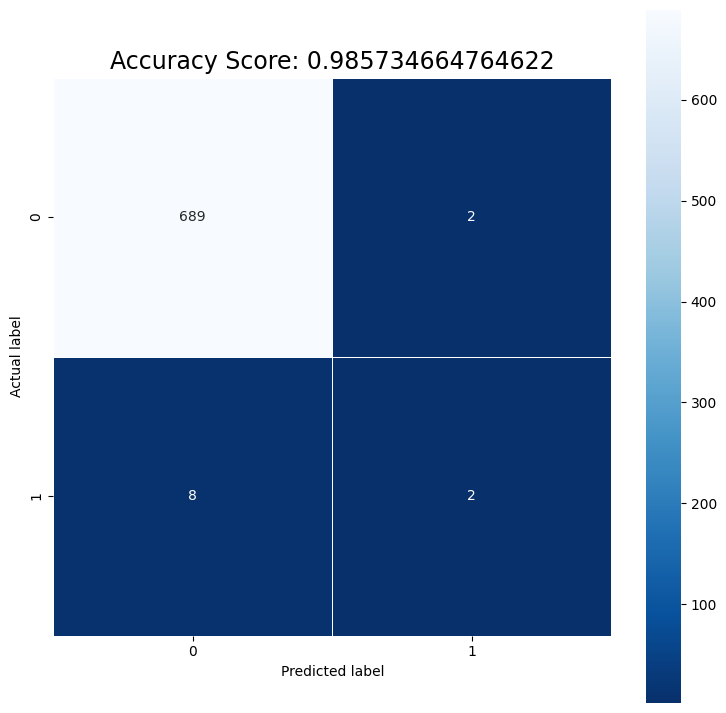

In [9]:
#predictors_array = predictors_chi_original
r = 42
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Java Test and Train Dataset
x_train_java_binary, x_test_java_binary, y_train_java_binary, y_test_java_binary = train_test_split(java_binary_predictors, java_binary_targets, test_size = 0.3, random_state = r)
x_train_java_multiclass, x_test_java_multiclass, y_train_java_multiclass, y_test_java_multiclass = train_test_split(java_multiclass_predictors, java_multiclass_targets, test_size = 0.3, random_state = r)

# Create a StandardScaler instance for binary and multiclass
from sklearn.preprocessing import StandardScaler
scaler_binary = StandardScaler()
scaler_multiclass = StandardScaler()

# Fit the scaler to the training data and transform the training data
x_train_java_binary = scaler_binary.fit_transform(x_train_java_binary)
x_train_java_multiclass = scaler_multiclass.fit_transform(x_train_java_multiclass)

# CSharp Test and Train Dataset
x_train_csharp_binary, x_test_csharp_binary, y_train_csharp_binary, y_test_csharp_binary = train_test_split(csharp_binary_predictors, csharp_binary_targets, test_size = 0.3, random_state = r, stratify=csharp_multiclass_targets)
x_train_csharp_multiclass, x_test_csharp_multiclass, y_train_csharp_multiclass, y_test_csharp_multiclass = train_test_split(csharp_multiclass_predictors, csharp_multiclass_targets, test_size = 0.3, random_state = r, stratify=csharp_multiclass_targets)

# Create a StandardScaler instance for binary and multiclass
scaler_binary = StandardScaler()
scaler_multiclass = StandardScaler()

# Fit the scaler to the training data and transform the training data
x_train_csharp_binary = scaler_binary.fit_transform(x_train_csharp_binary)
x_train_csharp_multiclass = scaler_multiclass.fit_transform(x_train_csharp_multiclass)

# Transform the test data using the adjusted scaler
x_test_csharp_binary = scaler_binary.transform(x_test_csharp_binary)
x_test_csharp_multiclass = scaler_multiclass.transform(x_test_csharp_multiclass)

# Combine Binary Training Dataset
x_train_binary_combined = np.concatenate([x_train_java_binary, x_train_csharp_binary], axis=0)
y_train_binary_combined = np.concatenate([y_train_java_binary, y_train_csharp_binary], axis=0)

# Combine Multiclass Training Dataset
x_train_multiclass_combined = np.concatenate([x_train_java_multiclass, x_train_csharp_multiclass], axis=0)
y_train_multiclass_combined = np.concatenate([y_train_java_multiclass, y_train_csharp_multiclass], axis=0)

# Define the detector model
detector = CatBoostClassifier(task_type='CPU', random_state = 42, verbose=False,
                              auto_class_weights='Balanced', bootstrap_type='MVS', border_count=251, depth=10, feature_border_type='GreedyLogSum',
                              grow_policy='SymmetricTree', iterations=915, l2_leaf_reg=7, leaf_estimation_method='Newton', learning_rate=0.5)

detector.fit(x_train_binary_combined, y_train_binary_combined)

# Define Binary Test Dataset
x_test_binary, y_test_binary = x_test_csharp_binary, y_test_csharp_binary

predictions_detector = detector.predict(x_test_binary)

cm = confusion_matrix(y_test_binary, predictions_detector)

print(classification_report(y_test_binary, predictions_detector))

score = detector.score(x_test_binary, y_test_binary)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 17)
#plt.savefig('toy_Digits_ConfusionSeabornCodementor.png')
plt.show()

## **BorderlineSMOTE**

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       691
           1       0.33      0.40      0.36        10

    accuracy                           0.98       701
   macro avg       0.66      0.69      0.68       701
weighted avg       0.98      0.98      0.98       701



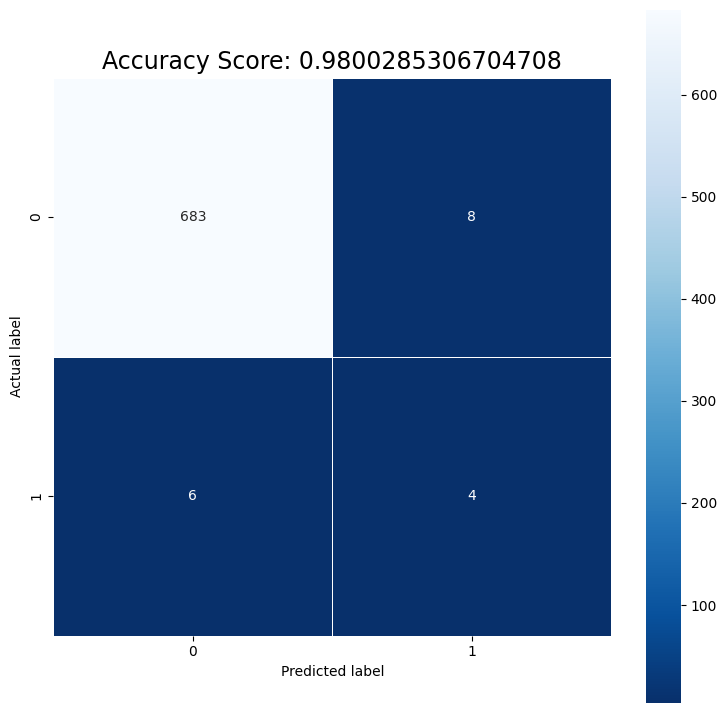

In [10]:
#predictors_array = predictors_chi_original
r = 42
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Java Test and Train Dataset
x_train_java_binary, x_test_java_binary, y_train_java_binary, y_test_java_binary = train_test_split(java_binary_predictors, java_binary_targets, test_size = 0.3, random_state = r)
x_train_java_multiclass, x_test_java_multiclass, y_train_java_multiclass, y_test_java_multiclass = train_test_split(java_multiclass_predictors, java_multiclass_targets, test_size = 0.3, random_state = r)

# Create a StandardScaler instance for binary and multiclass
from sklearn.preprocessing import StandardScaler
scaler_binary = StandardScaler()
scaler_multiclass = StandardScaler()

# Fit the scaler to the training data and transform the training data
x_train_java_binary = scaler_binary.fit_transform(x_train_java_binary)
x_train_java_multiclass = scaler_multiclass.fit_transform(x_train_java_multiclass)

# CSharp Test and Train Dataset
x_train_csharp_binary, x_test_csharp_binary, y_train_csharp_binary, y_test_csharp_binary = train_test_split(csharp_binary_predictors, csharp_binary_targets, test_size = 0.3, random_state = r, stratify=csharp_multiclass_targets)
x_train_csharp_multiclass, x_test_csharp_multiclass, y_train_csharp_multiclass, y_test_csharp_multiclass = train_test_split(csharp_multiclass_predictors, csharp_multiclass_targets, test_size = 0.3, random_state = r, stratify=csharp_multiclass_targets)

# Create a StandardScaler instance for binary and multiclass
scaler_binary = StandardScaler()
scaler_multiclass = StandardScaler()

# Fit the scaler to the training data and transform the training data
x_train_csharp_binary = scaler_binary.fit_transform(x_train_csharp_binary)
x_train_csharp_multiclass = scaler_multiclass.fit_transform(x_train_csharp_multiclass)

# Transform the test data using the adjusted scaler
x_test_csharp_binary = scaler_binary.transform(x_test_csharp_binary)
x_test_csharp_multiclass = scaler_multiclass.transform(x_test_csharp_multiclass)

# OverSampling
from imblearn.over_sampling import BorderlineSMOTE
sm = BorderlineSMOTE(random_state=42)
x_train_csharp_binary, y_train_csharp_binary = sm.fit_resample(x_train_csharp_binary, y_train_csharp_binary)

# Combine Binary Training Dataset
x_train_binary_combined = np.concatenate([x_train_java_binary, x_train_csharp_binary], axis=0)
y_train_binary_combined = np.concatenate([y_train_java_binary, y_train_csharp_binary], axis=0)

# Combine Multiclass Training Dataset
x_train_multiclass_combined = np.concatenate([x_train_java_multiclass, x_train_csharp_multiclass], axis=0)
y_train_multiclass_combined = np.concatenate([y_train_java_multiclass, y_train_csharp_multiclass], axis=0)

# Define the detector model
detector = CatBoostClassifier(task_type='CPU', random_state = 42, verbose=False,
                              auto_class_weights='Balanced', bootstrap_type='MVS', border_count=251, depth=10, feature_border_type='GreedyLogSum',
                              grow_policy='SymmetricTree', iterations=915, l2_leaf_reg=7, leaf_estimation_method='Newton', learning_rate=0.5)

detector.fit(x_train_binary_combined, y_train_binary_combined)

# Define Binary Test Dataset
x_test_binary, y_test_binary = x_test_csharp_binary, y_test_csharp_binary

predictions_detector = detector.predict(x_test_binary)

cm = confusion_matrix(y_test_binary, predictions_detector)

print(classification_report(y_test_binary, predictions_detector))

score = detector.score(x_test_binary, y_test_binary)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 17)
#plt.savefig('toy_Digits_ConfusionSeabornCodementor.png')
plt.show()

## **SMOTE**

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       691
           1       0.33      0.30      0.32        10

    accuracy                           0.98       701
   macro avg       0.66      0.65      0.65       701
weighted avg       0.98      0.98      0.98       701



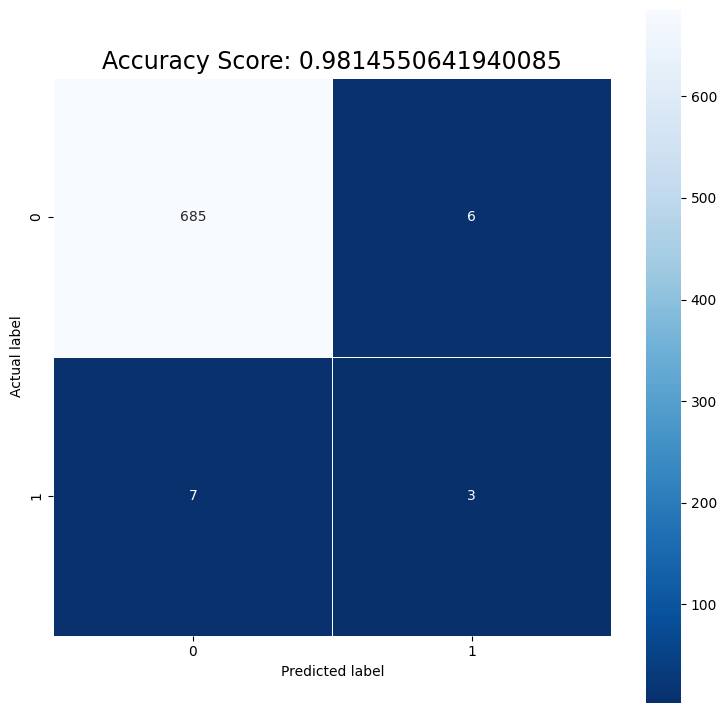

In [11]:
#predictors_array = predictors_chi_original
r = 42
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Java Test and Train Dataset
x_train_java_binary, x_test_java_binary, y_train_java_binary, y_test_java_binary = train_test_split(java_binary_predictors, java_binary_targets, test_size = 0.3, random_state = r)
x_train_java_multiclass, x_test_java_multiclass, y_train_java_multiclass, y_test_java_multiclass = train_test_split(java_multiclass_predictors, java_multiclass_targets, test_size = 0.3, random_state = r)

# Create a StandardScaler instance for binary and multiclass
from sklearn.preprocessing import StandardScaler
scaler_binary = StandardScaler()
scaler_multiclass = StandardScaler()

# Fit the scaler to the training data and transform the training data
x_train_java_binary = scaler_binary.fit_transform(x_train_java_binary)
x_train_java_multiclass = scaler_multiclass.fit_transform(x_train_java_multiclass)

# CSharp Test and Train Dataset
x_train_csharp_binary, x_test_csharp_binary, y_train_csharp_binary, y_test_csharp_binary = train_test_split(csharp_binary_predictors, csharp_binary_targets, test_size = 0.3, random_state = r, stratify=csharp_multiclass_targets)
x_train_csharp_multiclass, x_test_csharp_multiclass, y_train_csharp_multiclass, y_test_csharp_multiclass = train_test_split(csharp_multiclass_predictors, csharp_multiclass_targets, test_size = 0.3, random_state = r, stratify=csharp_multiclass_targets)

# Create a StandardScaler instance for binary and multiclass
scaler_binary = StandardScaler()
scaler_multiclass = StandardScaler()

# Fit the scaler to the training data and transform the training data
x_train_csharp_binary = scaler_binary.fit_transform(x_train_csharp_binary)
x_train_csharp_multiclass = scaler_multiclass.fit_transform(x_train_csharp_multiclass)

# Transform the test data using the adjusted scaler
x_test_csharp_binary = scaler_binary.transform(x_test_csharp_binary)
x_test_csharp_multiclass = scaler_multiclass.transform(x_test_csharp_multiclass)

# OverSampling
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
x_train_csharp_binary, y_train_csharp_binary = sm.fit_resample(x_train_csharp_binary, y_train_csharp_binary)

# Combine Binary Training Dataset
x_train_binary_combined = np.concatenate([x_train_java_binary, x_train_csharp_binary], axis=0)
y_train_binary_combined = np.concatenate([y_train_java_binary, y_train_csharp_binary], axis=0)

# Combine Multiclass Training Dataset
x_train_multiclass_combined = np.concatenate([x_train_java_multiclass, x_train_csharp_multiclass], axis=0)
y_train_multiclass_combined = np.concatenate([y_train_java_multiclass, y_train_csharp_multiclass], axis=0)

# Define the detector model
detector = CatBoostClassifier(task_type='CPU', random_state = 42, verbose=False,
                              auto_class_weights='Balanced', bootstrap_type='MVS', border_count=251, depth=10, feature_border_type='GreedyLogSum',
                              grow_policy='SymmetricTree', iterations=915, l2_leaf_reg=7, leaf_estimation_method='Newton', learning_rate=0.5)

detector.fit(x_train_binary_combined, y_train_binary_combined)

# Define Binary Test Dataset
x_test_binary, y_test_binary = x_test_csharp_binary, y_test_csharp_binary

predictions_detector = detector.predict(x_test_binary)

cm = confusion_matrix(y_test_binary, predictions_detector)

print(classification_report(y_test_binary, predictions_detector))

score = detector.score(x_test_binary, y_test_binary)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 17)
#plt.savefig('toy_Digits_ConfusionSeabornCodementor.png')
plt.show()

# **Exclude instances of no-smell from the training and test sets**


In [12]:
x_test_multiclass, y_test_multiclass = x_test_csharp_multiclass, y_test_csharp_multiclass

# Find unique classes
unique_classes = np.unique(y_test_multiclass)

# Count the number of classes
number_classes = len(unique_classes)

if (number_classes > 2):

  x_train_multiclass, y_train_multiclass = x_train_multiclass_combined, y_train_multiclass_combined

  finish = False
  while (finish == False):
    try:
      max = x_train_multiclass.shape[0]
      # Exclude instances of no-smell from the training set (targets)
      for i in range(0, max):
        if (y_train_multiclass[i] == 0):
          y_train_multiclass = np.delete(y_train_multiclass, i, axis = 0)
          x_train_multiclass = np.delete(x_train_multiclass, i, axis = 0)
          i = 0
          max = max - 1
      finish = True
      print("The deletion is over in the y_train set!")
    except:
      finish == False

  finish = False
  while (finish == False):
    try:
      max = x_test_multiclass.shape[0]
      # Exclude instances of no-smell from the test set (predictors)
      for i in range(0, max):
        if (y_test_multiclass[i] == 0):
          y_test_multiclass = np.delete(y_test_multiclass, i, axis = 0)
          x_test_multiclass = np.delete(x_test_multiclass, i, axis = 0)
          i = 0
          max = max - 1
      finish = True
      print("The deletion is over in the x_train set!")
    except:
      finish = False

  # Original mapping -> Remapping
  mapping = {1.0: 0.0, 2.0: 1.0, 3.0: 2.0, 4.0: 3.0, 5.0: 4.0, 6.0: 5.0, 7.0: 6.0, 8.0: 7.0, 9.0: 8.0, 10.0: 9.0, 11.0: 10.0, 12.0: 11.0}

  y_train_multiclass = np.array([mapping[label] for label in y_train_multiclass])
  y_test_multiclass = np.array([mapping[label] for label in y_test_multiclass])
  print("Prepare training and test set for applying XGBoost")

The deletion is over in the y_train set!
The deletion is over in the x_train set!
Prepare training and test set for applying XGBoost


# **Code Smell Severity Classification with three ensemble method**


# **RANDOM FOREST**

# **Oversampling BorderlineSMOTE**

In [13]:
pip install imbalanced-learn

# **Randomized**

              precision    recall  f1-score   support

         0.0       0.67      0.50      0.57         8
         1.0       0.00      0.00      0.00         2
         3.0       0.00      0.00      0.00         0
         4.0       0.00      0.00      0.00         0

    accuracy                           0.40        10
   macro avg       0.17      0.12      0.14        10
weighted avg       0.53      0.40      0.46        10



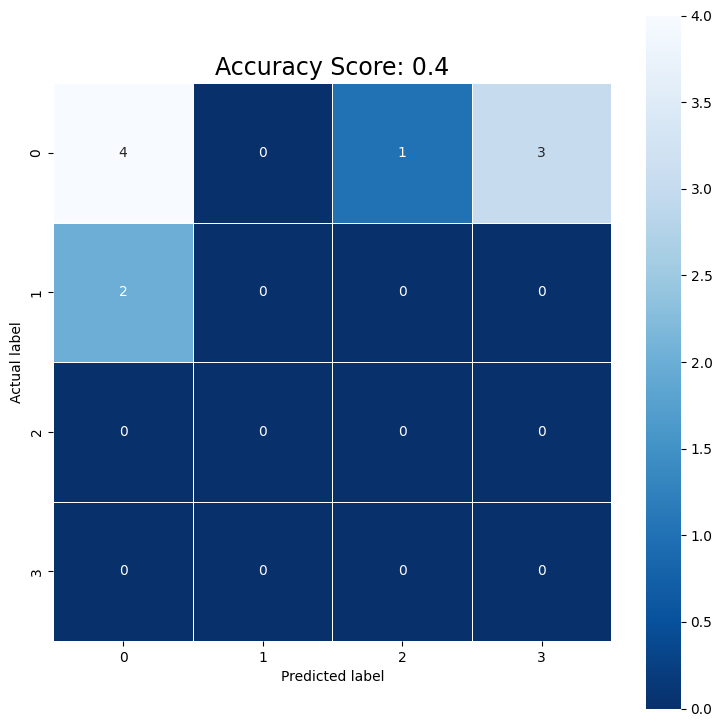

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Define the classifier model
classifier = RandomForestClassifier(random_state=42, n_estimators=970, min_samples_split=7, min_samples_leaf=3, max_features=None, max_depth=6,
                                    criterion='log_loss', bootstrap=True)

classifier.fit(x_train_multiclass, y_train_multiclass)

predictions_classifier = classifier.predict(x_test_multiclass)

cm = confusion_matrix(y_test_multiclass, predictions_classifier)

print(classification_report(y_test_multiclass, predictions_classifier))

score = classifier.score(x_test_multiclass, y_test_multiclass)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 17)
#plt.savefig('toy_Digits_ConfusionSeabornCodementor.png')
plt.show()

# **BorderlineSMOTE**

In [15]:
from imblearn.over_sampling import BorderlineSMOTE

# OverSampling
sm = BorderlineSMOTE(random_state=42)
x_train_multiclass_res, y_train_multiclass_res = sm.fit_resample(x_train_multiclass, y_train_multiclass)

              precision    recall  f1-score   support

         0.0       0.88      0.88      0.88         8
         1.0       0.00      0.00      0.00         2
         4.0       0.00      0.00      0.00         0
         5.0       0.00      0.00      0.00         0

    accuracy                           0.70        10
   macro avg       0.22      0.22      0.22        10
weighted avg       0.70      0.70      0.70        10



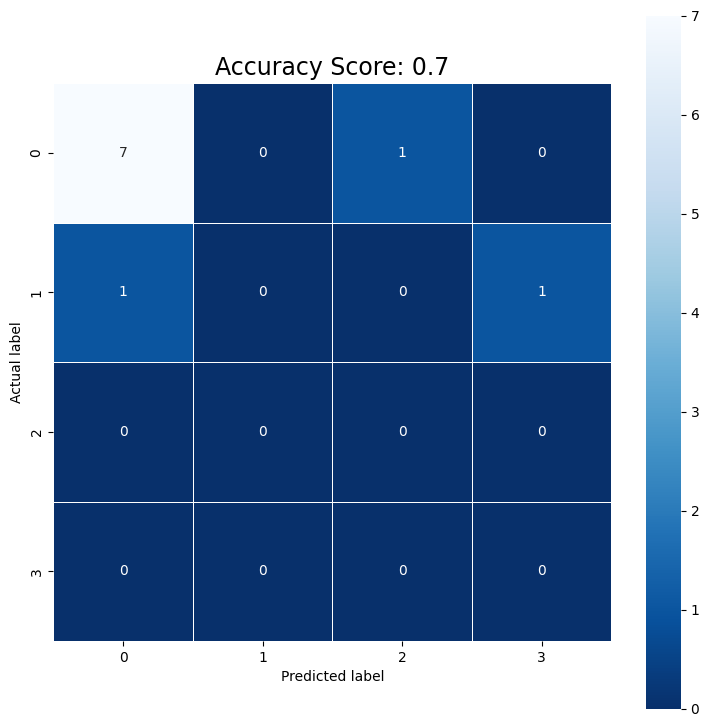

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Define the classifier model
classifier = RandomForestClassifier(random_state=42, n_estimators=118, min_samples_split=12, min_samples_leaf=3, max_features='sqrt', max_depth=9,
                                    criterion='gini', bootstrap=False)

classifier.fit(x_train_multiclass_res, y_train_multiclass_res)

predictions_classifier = classifier.predict(x_test_multiclass)

cm = confusion_matrix(y_test_multiclass, predictions_classifier)

print(classification_report(y_test_multiclass, predictions_classifier))

score = classifier.score(x_test_multiclass, y_test_multiclass)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 17)
#plt.savefig('toy_Digits_ConfusionSeabornCodementor.png')
plt.show()

## **SMOTE**

In [17]:
from imblearn.over_sampling import SMOTE

# OverSampling
sm = SMOTE(random_state=42)
x_train_multiclass_res, y_train_multiclass_res = sm.fit_resample(x_train_multiclass, y_train_multiclass)

              precision    recall  f1-score   support

         0.0       0.78      0.88      0.82         8
         1.0       0.00      0.00      0.00         2
         4.0       0.00      0.00      0.00         0

    accuracy                           0.70        10
   macro avg       0.26      0.29      0.27        10
weighted avg       0.62      0.70      0.66        10



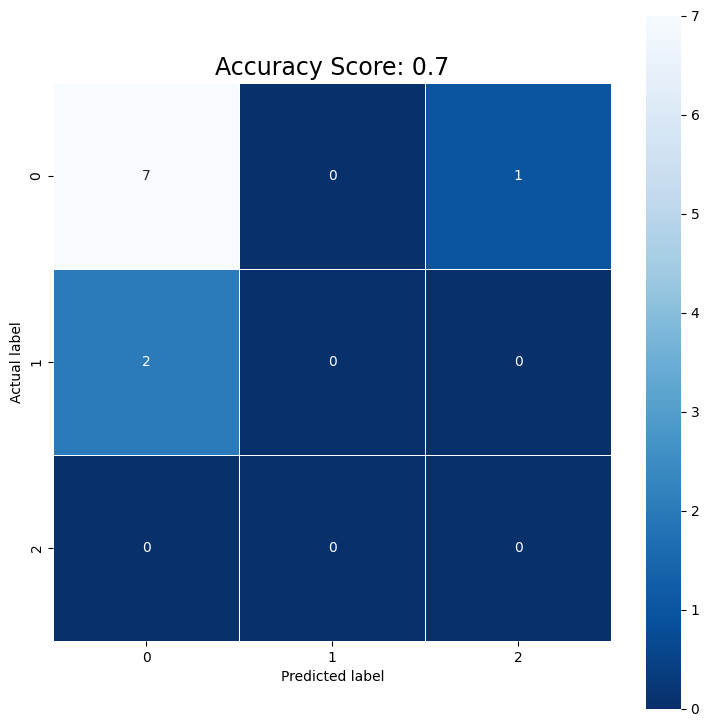

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Define the classifier model
classifier = RandomForestClassifier(random_state=42, n_estimators=416, min_samples_split=8, min_samples_leaf=1, max_features='log2', max_depth=6,
                                    criterion='log_loss', bootstrap=False)

classifier.fit(x_train_multiclass_res, y_train_multiclass_res)

predictions_classifier = classifier.predict(x_test_multiclass)

cm = confusion_matrix(y_test_multiclass, predictions_classifier)

print(classification_report(y_test_multiclass, predictions_classifier))

score = classifier.score(x_test_multiclass, y_test_multiclass)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 17)
#plt.savefig('toy_Digits_ConfusionSeabornCodementor.png')
plt.show()

# **EXTREME GRADIENTE BOOSTING (XGBOOST)**

# **Randomized**

              precision    recall  f1-score   support

         0.0       0.78      0.88      0.82         8
         1.0       0.00      0.00      0.00         2

    accuracy                           0.70        10
   macro avg       0.39      0.44      0.41        10
weighted avg       0.62      0.70      0.66        10



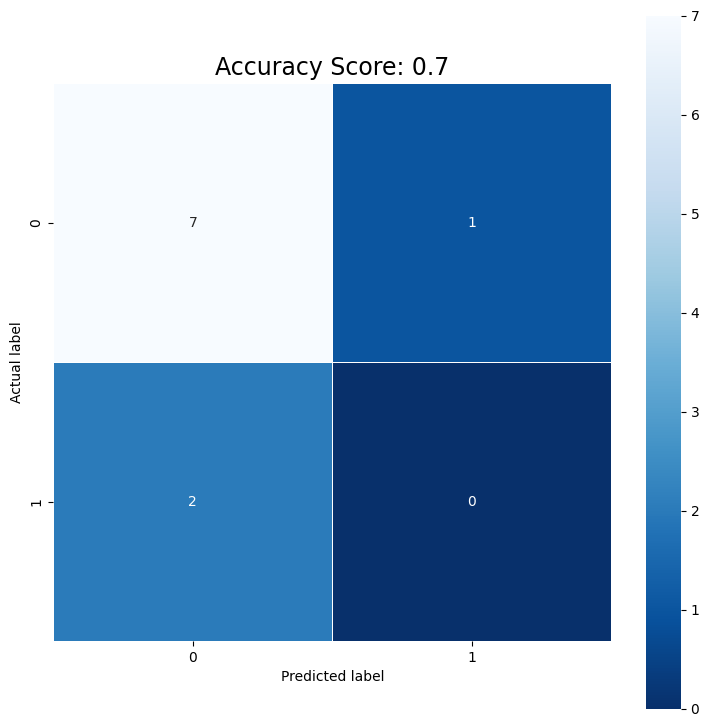

In [19]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Define the classifier model
classifier = XGBClassifier(num_class=12, random_state=42, tree_method='hist', objective='multi:softmax', n_estimators=786, max_depth=5,
                           learning_rate=0.11137931034482758, grow_policy='lossguide', booster='dart')

classifier.fit(x_train_multiclass, y_train_multiclass)

predictions_classifier = classifier.predict(x_test_multiclass)

cm = confusion_matrix(y_test_multiclass, predictions_classifier)

print(classification_report(y_test_multiclass, predictions_classifier))

score = classifier.score(x_test_multiclass, y_test_multiclass)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 17)
#plt.savefig('toy_Digits_ConfusionSeabornCodementor.png')
plt.show()

# **BorderlineSMOTE**

In [20]:
from imblearn.over_sampling import BorderlineSMOTE

# OverSampling
sm = BorderlineSMOTE(random_state=42)
x_train_multiclass_res, y_train_multiclass_res = sm.fit_resample(x_train_multiclass, y_train_multiclass)

              precision    recall  f1-score   support

         0.0       0.83      0.62      0.71         8
         1.0       0.00      0.00      0.00         2
         5.0       0.00      0.00      0.00         0

    accuracy                           0.50        10
   macro avg       0.28      0.21      0.24        10
weighted avg       0.67      0.50      0.57        10



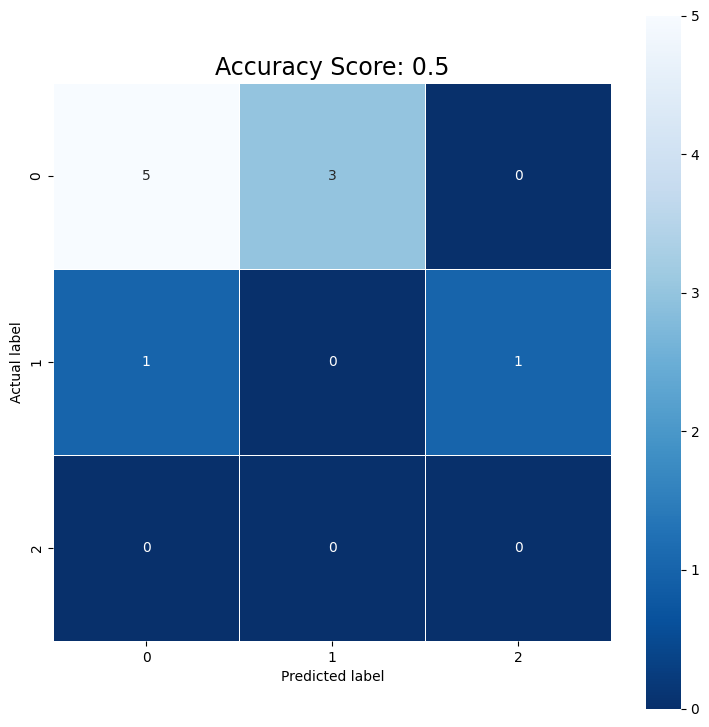

In [21]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Define the classifier model
classifier = XGBClassifier(num_class=12, random_state=42, tree_method='hist', objective='multi:softprob', n_estimators=164, max_depth=1,
                           learning_rate=0.48310344827586205, grow_policy='lossguide', booster='dart')

classifier.fit(x_train_multiclass_res, y_train_multiclass_res)

predictions_classifier = classifier.predict(x_test_multiclass)

cm = confusion_matrix(y_test_multiclass, predictions_classifier)

print(classification_report(y_test_multiclass, predictions_classifier))

score = classifier.score(x_test_multiclass, y_test_multiclass)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 17)
#plt.savefig('toy_Digits_ConfusionSeabornCodementor.png')
plt.show()

## **SMOTE**

In [22]:
from imblearn.over_sampling import SMOTE

# OverSampling
sm = SMOTE(random_state=42)
x_train_multiclass_res, y_train_multiclass_res = sm.fit_resample(x_train_multiclass, y_train_multiclass)

              precision    recall  f1-score   support

         0.0       0.78      0.88      0.82         8
         1.0       0.00      0.00      0.00         2

    accuracy                           0.70        10
   macro avg       0.39      0.44      0.41        10
weighted avg       0.62      0.70      0.66        10



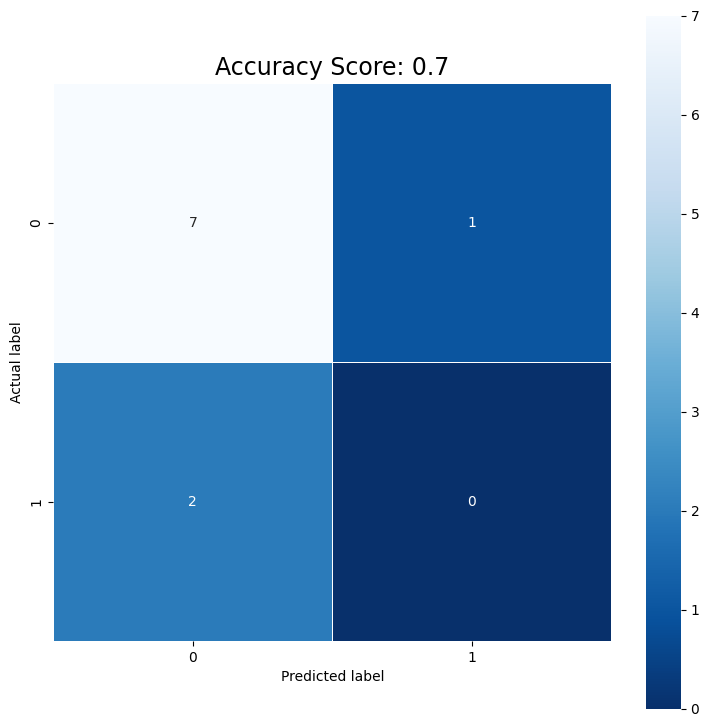

In [23]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Define the classifier model
classifier = XGBClassifier(num_class=12, random_state=42, tree_method='approx', objective='multi:softmax', n_estimators=852, max_depth=4,
                           learning_rate=0.19586206896551722, grow_policy='depthwise', booster='dart')

classifier.fit(x_train_multiclass_res, y_train_multiclass_res)

predictions_classifier = classifier.predict(x_test_multiclass)

cm = confusion_matrix(y_test_multiclass, predictions_classifier)

print(classification_report(y_test_multiclass, predictions_classifier))

score = classifier.score(x_test_multiclass, y_test_multiclass)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 17)
#plt.savefig('toy_Digits_ConfusionSeabornCodementor.png')
plt.show()

# **CATEGORICAL BOOSTING (CATBOOST)**

In [24]:
pip install catboost

# **Randomized**

              precision    recall  f1-score   support

         0.0       0.75      0.75      0.75         8
         1.0       0.00      0.00      0.00         2
         4.0       0.00      0.00      0.00         0
         5.0       0.00      0.00      0.00         0

    accuracy                           0.60        10
   macro avg       0.19      0.19      0.19        10
weighted avg       0.60      0.60      0.60        10



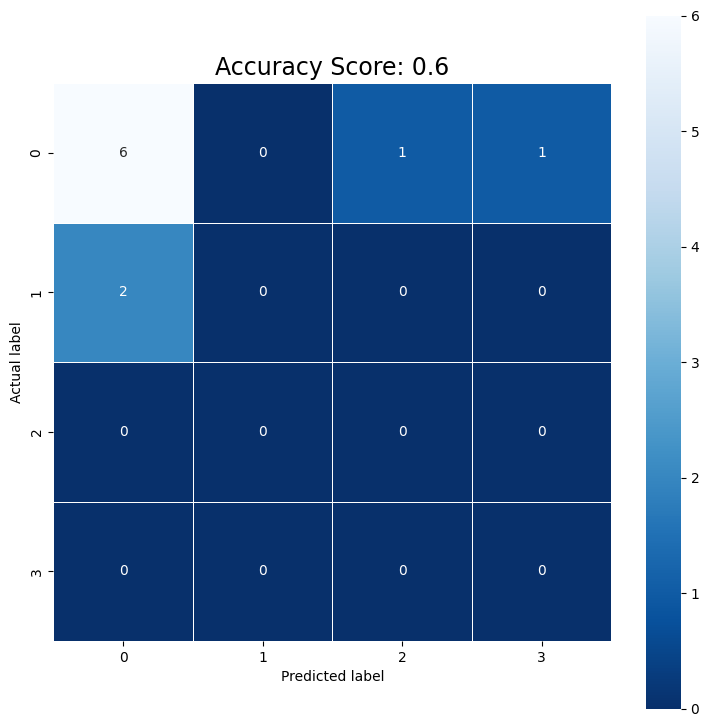

In [25]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Define the classifier model
classifier = CatBoostClassifier(task_type='CPU', random_state = 42, verbose=False, classes_count=12, objective='MultiClass',
                                learning_rate=0.04379310344827586, leaf_estimation_method='Newton', l2_leaf_reg=8, iterations=354, grow_policy='Lossguide',
                                feature_border_type='MaxLogSum', depth=6, border_count=96, bootstrap_type='No', auto_class_weights='SqrtBalanced')

classifier.fit(x_train_multiclass, y_train_multiclass)

predictions_classifier = classifier.predict(x_test_multiclass)

cm = confusion_matrix(y_test_multiclass, predictions_classifier)

print(classification_report(y_test_multiclass, predictions_classifier))

score = classifier.score(x_test_multiclass, y_test_multiclass)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 17)
#plt.savefig('toy_Digits_ConfusionSeabornCodementor.png')
plt.show()

# **BorderlineSMOTE**

In [26]:
from imblearn.over_sampling import BorderlineSMOTE

# OverSampling
sm = BorderlineSMOTE(random_state=42)
x_train_multiclass_res, y_train_multiclass_res = sm.fit_resample(x_train_multiclass, y_train_multiclass)

              precision    recall  f1-score   support

         0.0       0.78      0.88      0.82         8
         1.0       0.00      0.00      0.00         2

    accuracy                           0.70        10
   macro avg       0.39      0.44      0.41        10
weighted avg       0.62      0.70      0.66        10



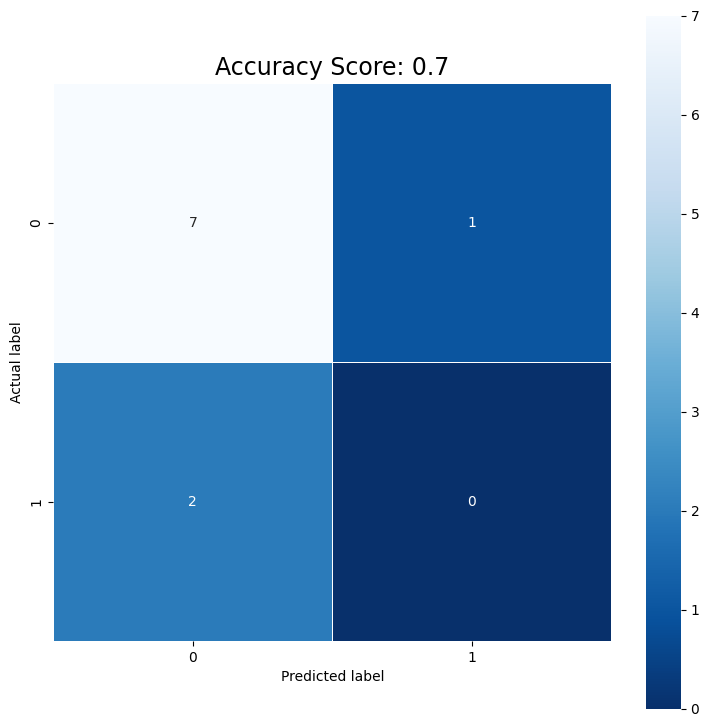

In [27]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Define the classifier model
classifier = CatBoostClassifier(task_type='CPU', random_state = 42, verbose=False, classes_count=12, objective='MultiClass',
                                learning_rate=0.3986206896551724, leaf_estimation_method='Newton', l2_leaf_reg=7, iterations=396, grow_policy='Depthwise',
                                feature_border_type='UniformAndQuantiles', depth=15, border_count=128, bootstrap_type='Bernoulli', auto_class_weights='SqrtBalanced')

classifier.fit(x_train_multiclass_res, y_train_multiclass_res)

predictions_classifier = classifier.predict(x_test_multiclass)

cm = confusion_matrix(y_test_multiclass, predictions_classifier)

print(classification_report(y_test_multiclass, predictions_classifier))

score = classifier.score(x_test_multiclass, y_test_multiclass)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 17)
#plt.savefig('toy_Digits_ConfusionSeabornCodementor.png')
plt.show()

## **SMOTE**

In [28]:
from imblearn.over_sampling import SMOTE

# OverSampling
sm = SMOTE(random_state=42)
x_train_multiclass_res, y_train_multiclass_res = sm.fit_resample(x_train_multiclass, y_train_multiclass)

              precision    recall  f1-score   support

         0.0       0.78      0.88      0.82         8
         1.0       0.00      0.00      0.00         2

    accuracy                           0.70        10
   macro avg       0.39      0.44      0.41        10
weighted avg       0.62      0.70      0.66        10



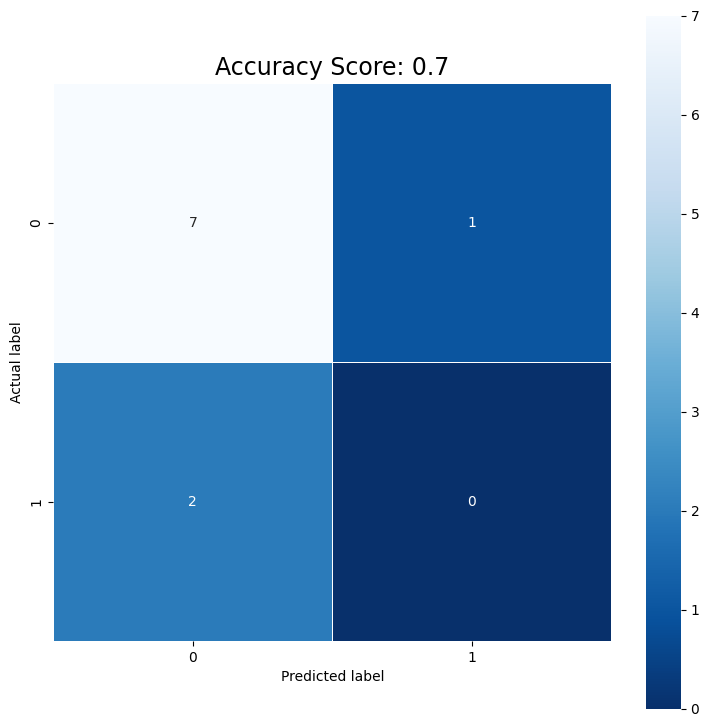

In [29]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Define the classifier model
classifier = CatBoostClassifier(task_type='CPU', random_state = 42, verbose=False, classes_count=12, objective='MultiClass',
                                learning_rate=0.3479310344827586, leaf_estimation_method='Gradient', l2_leaf_reg=5, iterations=910, grow_policy='Lossguide',
                                feature_border_type='Uniform', depth=12, border_count=192, bootstrap_type='Bayesian', auto_class_weights='Balanced')

classifier.fit(x_train_multiclass_res, y_train_multiclass_res)

predictions_classifier = classifier.predict(x_test_multiclass)

cm = confusion_matrix(y_test_multiclass, predictions_classifier)

print(classification_report(y_test_multiclass, predictions_classifier))

score = classifier.score(x_test_multiclass, y_test_multiclass)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 17)
#plt.savefig('toy_Digits_ConfusionSeabornCodementor.png')
plt.show()